In [1]:
### Kaggle Notebook Starter Cell ###

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

### Below code commented out after initial verification of files available - it takes forever to run ###

#import os

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
### Import necessary libraries ###

import pandas as pd
import numpy as np
import os 
import json 
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
 

Labels shape: (220025, 2)
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


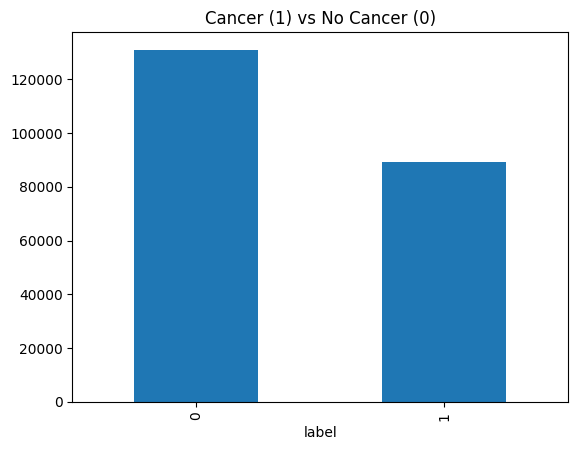

Cancer (label = 1):


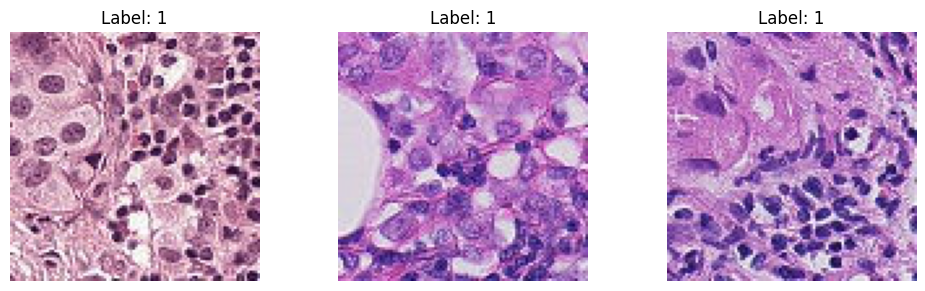

No Cancer (label = 0):


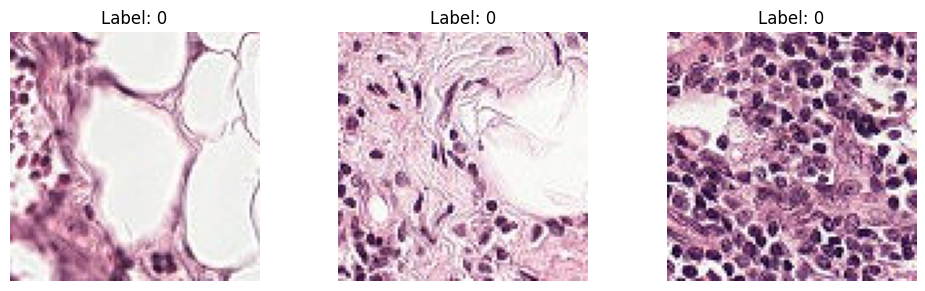

In [3]:
### Cell loads and explores data
### Loads the CSV and visualizes class distribution and image samples

# load training labels
labels = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
print('Labels shape:', labels.shape)
print(labels.head())

# show distribution of cancerous vs not
labels['label'].value_counts().plot(kind='bar', title='Cancer (1) vs No Cancer (0)')
plt.show()

# display 3 cancer and 3 non cancer images
def show_samples(label_value, n=3):
    sample_ids = labels[labels['label'] == label_value].sample(n)['id'].values
    plt.figure(figsize=(10, 3))
    for i, img_id in enumerate(sample_ids):
        img_path = f'/kaggle/input/histopathologic-cancer-detection/train/{img_id}.tif'
        img = Image.open(img_path)
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(f'Label: {label_value}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

print("Cancer (label = 1):")
show_samples(1)

print("No Cancer (label = 0):")
show_samples(0)


In [4]:
### Preprocess and prepare data set
### Limit to N_SAMPLES depending on use/priorities
### Normalizes and splits into train and validation (no need to resize, all 96x96)

# limit dataset for speed and/or my own impatience (3000 initially, tried increase to 10k, landed on 5k)
N_SAMPLES = 5000

#set image size. not strictly necessary as they're all the same size
IMG_SIZE = 96

#random sample of rows from labels data frame
sampled_df = labels.sample(N_SAMPLES, random_state=42).reset_index(drop=True) 

# function loads images and their labels
def load_images(df, img_dir):
    X = np.empty((len(df), IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8) #numpy array to hold image data
    y = df['label'].values  # get label values

    #loop through ea image id in data frame
    for i, img_id in enumerate(tqdm(df['id'], desc='Loading images')):
        img_path = f'{img_dir}/{img_id}.tif' 
        img = Image.open(img_path)
        X[i] = np.array(img)  # image to numpy array 
    return X, y 

#load/preprocess images from training 
X, y = load_images(sampled_df, '/kaggle/input/histopathologic-cancer-detection/train')

# normalize pixel values to 0-1 range 
X = X / 255.0

# split into train and val sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)


Loading images: 100%|██████████| 5000/5000 [00:47<00:00, 105.16it/s]


Train shape: (4000, 96, 96, 3)
Validation shape: (1000, 96, 96, 3)


In [5]:
# Define CNN model w/ keras sequential API
model = models.Sequential([

    #32 filters, 3x3 kernel, relu activation
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    layers.MaxPooling2D((2, 2)),

    # 64 filters " ... "
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # 128 filters " ... "
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # flatten feature maps to 1D vector
    layers.Flatten(),
    #dense connected layer w/ 128 neurons
    layers.Dense(128, activation='relu'),
    # 50% of units dropped randomly to prevent over fit
    layers.Dropout(0.5),
    # output 1 neuron and sigmoid activation or binary classificatoin
    layers.Dense(1, activation='sigmoid')
])

# compile model with loss and adam
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])  # track accuracy in training

model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 20, 20, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,638,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,731,905 (6.61 MB)

 Trainable params: 1,731,905 (6.61 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# train CNN 
history = model.fit(
    X_train, y_train, # features and labels
    epochs=5,  # # of passes through training data
    batch_size=32, # # of samples per gradient update
    validation_data=(X_val, y_val)  # data to check model after each epoch
)

Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 36s 268ms/step - accuracy: 0.5595 - loss: 0.6848 - val_accuracy: 0.7870 - val_loss: 0.4735
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 33s 263ms/step - accuracy: 0.7467 - loss: 0.5330 - val_accuracy: 0.7750 - val_loss: 0.4917
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 33s 260ms/step - accuracy: 0.7783 - loss: 0.4860 - val_accuracy: 0.7950 - val_loss: 0.4669
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 33s 264ms/step - accuracy: 0.7897 - loss: 0.4709 - val_accuracy: 0.7950 - val_loss: 0.4583
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 33s 262ms/step - accuracy: 0.7810 - loss: 0.4728 - val_accuracy: 0.7990 - val_loss: 0.4426


In [7]:
### Load test image ids from kaggle's sample submission (template?) 
### to guarantee correct order and # of rows

submission_template = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/sample_submission.csv')
test_ids = submission_template['id'].tolist()
test_dir = '/kaggle/input/histopathologic-cancer-detection/test/'

# if kernel dies, path to check point file w/ stored progress to lessen the amount of my hair ripped out
checkpoint_path = 'checkpoint.json'

# init prediction state
start_index = 0
predictions = []
ids = []

# if check point file exists and isn't empty, resume from there
if os.path.exists(checkpoint_path) and os.path.getsize(checkpoint_path) > 0:
    print("Resuming from checkpoint...")
    with open(checkpoint_path, 'r') as f:
        checkpoint = json.load(f)
    start_index = checkpoint['index']  # resume from this index
    predictions = checkpoint['predictions'] # saved predictions
    ids = checkpoint['ids']  #saved ids
else:
    print("No valid checkpoint found. Recommendation: cry about it, then start fresh.")

# loop and predict on each test image one at a time to prevent memory crashes
for i in tqdm(range(start_index, len(test_ids)), desc='Predicting'):
    img_id = test_ids[i]
    img_path = os.path.join(test_dir, f"{img_id}.tif")  # adds .tif to match filename

    # load/preprocess image
    img = Image.open(img_path)
    img_array = np.array(img).astype('float32') / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # shape: (1, 96, 96, 3)

    # predict w/ training model
    pred = float(model.predict(img_array, verbose=0)[0][0])
    predictions.append(pred)
    ids.append(img_id)

    # save progress every 1k predictions out of an abundance of caution (trauma) 
    # or victoriously at the end 
    if (i + 1) % 1000 == 0 or (i + 1) == len(test_ids):
        with open(checkpoint_path, 'w') as f:
            json.dump({
                'index': i + 1,
                'predictions': predictions,
                'ids': ids
            }, f)
        print(f"Checkpoint saved at index {i + 1}")


No valid checkpoint found. Recommendation: cry about it, then start fresh.


Predicting:   2%|▏         | 1001/57458 [01:25<1:47:26,  8.76it/s]

Checkpoint saved at index 1000


Predicting:   3%|▎         | 2001/57458 [03:18<1:44:06,  8.88it/s]

Checkpoint saved at index 2000


Predicting:   5%|▌         | 3001/57458 [05:15<1:48:55,  8.33it/s]

Checkpoint saved at index 3000


Predicting:   7%|▋         | 4000/57458 [06:55<1:27:03, 10.23it/s]

Checkpoint saved at index 4000


Predicting:   9%|▊         | 5001/57458 [08:19<1:12:28, 12.06it/s]

Checkpoint saved at index 5000


Predicting:  10%|█         | 6001/57458 [09:43<1:10:51, 12.10it/s]

Checkpoint saved at index 6000


Predicting:  12%|█▏        | 7001/57458 [11:05<1:12:35, 11.59it/s]

Checkpoint saved at index 7000


Predicting:  14%|█▍        | 8001/57458 [12:29<1:11:36, 11.51it/s]

Checkpoint saved at index 8000


Predicting:  16%|█▌        | 9002/57458 [13:58<1:11:21, 11.32it/s]

Checkpoint saved at index 9000


Predicting:  17%|█▋        | 10001/57458 [15:27<1:11:20, 11.09it/s]

Checkpoint saved at index 10000


Predicting:  19%|█▉        | 11001/57458 [16:54<1:06:31, 11.64it/s]

Checkpoint saved at index 11000


Predicting:  21%|██        | 12002/57458 [18:19<1:03:19, 11.96it/s]

Checkpoint saved at index 12000


Predicting:  23%|██▎       | 13002/57458 [19:42<1:04:01, 11.57it/s]

Checkpoint saved at index 13000


Predicting:  24%|██▍       | 14002/57458 [21:07<1:06:50, 10.83it/s]

Checkpoint saved at index 14000


Predicting:  26%|██▌       | 15002/57458 [22:30<1:00:14, 11.74it/s]

Checkpoint saved at index 15000


Predicting:  28%|██▊       | 16002/57458 [23:55<58:30, 11.81it/s]

Checkpoint saved at index 16000


Predicting:  30%|██▉       | 17002/57458 [25:17<58:16, 11.57it/s]

Checkpoint saved at index 17000


Predicting:  31%|███▏      | 18001/57458 [26:42<58:28, 11.25it/s]

Checkpoint saved at index 18000


Predicting:  33%|███▎      | 19001/57458 [28:04<53:59, 11.87it/s]

Checkpoint saved at index 19000


Predicting:  35%|███▍      | 20001/57458 [29:28<54:10, 11.52it/s]

Checkpoint saved at index 20000


Predicting:  37%|███▋      | 21001/57458 [30:50<53:02, 11.45it/s]

Checkpoint saved at index 21000


Predicting:  38%|███▊      | 22001/57458 [32:15<55:10, 10.71it/s]

Checkpoint saved at index 22000


Predicting:  40%|████      | 23001/57458 [33:37<55:17, 10.39it/s]

Checkpoint saved at index 23000


Predicting:  42%|████▏     | 24001/57458 [35:01<50:32, 11.03it/s]

Checkpoint saved at index 24000


Predicting:  44%|████▎     | 25001/57458 [36:24<50:46, 10.65it/s]

Checkpoint saved at index 25000


Predicting:  45%|████▌     | 26001/57458 [37:48<47:09, 11.12it/s]

Checkpoint saved at index 26000


Predicting:  47%|████▋     | 27001/57458 [39:11<51:32,  9.85it/s]

Checkpoint saved at index 27000


Predicting:  49%|████▊     | 28001/57458 [40:40<50:41,  9.69it/s]

Checkpoint saved at index 28000


Predicting:  50%|█████     | 29001/57458 [42:07<46:51, 10.12it/s]

Checkpoint saved at index 29000


Predicting:  52%|█████▏    | 30001/57458 [43:35<41:44, 10.96it/s]

Checkpoint saved at index 30000


Predicting:  54%|█████▍    | 31001/57458 [45:01<44:05, 10.00it/s]

Checkpoint saved at index 31000


Predicting:  56%|█████▌    | 32001/57458 [46:26<39:33, 10.73it/s]

Checkpoint saved at index 32000


Predicting:  57%|█████▋    | 33001/57458 [47:51<40:04, 10.17it/s]

Checkpoint saved at index 33000


Predicting:  59%|█████▉    | 34001/57458 [49:16<35:43, 10.94it/s]

Checkpoint saved at index 34000


Predicting:  61%|██████    | 35001/57458 [50:43<36:49, 10.16it/s]

Checkpoint saved at index 35000


Predicting:  63%|██████▎   | 36001/57458 [52:07<33:21, 10.72it/s]

Checkpoint saved at index 36000


Predicting:  64%|██████▍   | 37001/57458 [53:33<34:56,  9.76it/s]

Checkpoint saved at index 37000


Predicting:  66%|██████▌   | 38001/57458 [54:59<32:08, 10.09it/s]

Checkpoint saved at index 38000


Predicting:  68%|██████▊   | 39001/57458 [56:27<32:38,  9.43it/s]

Checkpoint saved at index 39000


Predicting:  70%|██████▉   | 40002/57458 [57:54<27:08, 10.72it/s]

Checkpoint saved at index 40000


Predicting:  71%|███████▏  | 41001/57458 [59:23<27:46,  9.88it/s]

Checkpoint saved at index 41000


Predicting:  73%|███████▎  | 42001/57458 [1:00:49<24:45, 10.40it/s]

Checkpoint saved at index 42000


Predicting:  75%|███████▍  | 43001/57458 [1:02:17<25:01,  9.63it/s]

Checkpoint saved at index 43000


Predicting:  77%|███████▋  | 44001/57458 [1:03:45<21:52, 10.26it/s]

Checkpoint saved at index 44000


Predicting:  78%|███████▊  | 45001/57458 [1:05:12<20:38, 10.06it/s]

Checkpoint saved at index 45000


Predicting:  80%|████████  | 46001/57458 [1:06:37<18:42, 10.20it/s]

Checkpoint saved at index 46000


Predicting:  82%|████████▏ | 47001/57458 [1:08:04<16:58, 10.26it/s]

Checkpoint saved at index 47000


Predicting:  84%|████████▎ | 48002/57458 [1:09:31<19:40,  8.01it/s]

Checkpoint saved at index 48000


Predicting:  85%|████████▌ | 49002/57458 [1:10:58<13:17, 10.60it/s]

Checkpoint saved at index 49000


Predicting:  87%|████████▋ | 50002/57458 [1:12:24<12:17, 10.11it/s]

Checkpoint saved at index 50000


Predicting:  89%|████████▉ | 51001/57458 [1:13:51<11:25,  9.42it/s]

Checkpoint saved at index 51000


Predicting:  91%|█████████ | 52001/57458 [1:15:17<09:47,  9.30it/s]

Checkpoint saved at index 52000


Predicting:  92%|█████████▏| 53001/57458 [1:16:45<07:51,  9.45it/s]

Checkpoint saved at index 53000


Predicting:  94%|█████████▍| 54001/57458 [1:18:12<06:10,  9.34it/s]

Checkpoint saved at index 54000


Predicting:  96%|█████████▌| 55001/57458 [1:19:38<04:10,  9.80it/s]

Checkpoint saved at index 55000


Predicting:  97%|█████████▋| 56001/57458 [1:21:03<02:31,  9.64it/s]

Checkpoint saved at index 56000


Predicting:  99%|█████████▉| 57001/57458 [1:22:29<00:46,  9.91it/s]

Checkpoint saved at index 57000


Predicting: 100%|██████████| 57458/57458 [1:23:08<00:00, 11.52it/s]

Checkpoint saved at index 57458


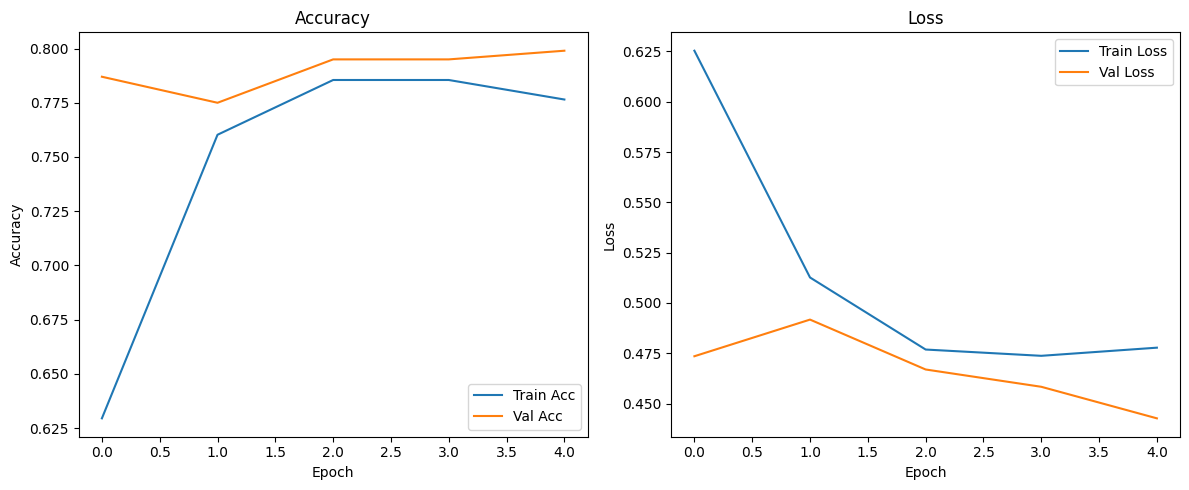

In [8]:
# visualize and plot training and val accuracy/loss over epochs
plt.figure(figsize=(12, 5))

# accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [9]:
# make DF w/ required format for kaggle submission 
# using image ids from test set and predicted probabilities 
submission_df = pd.DataFrame({
    'id': ids,   
    'label': predictions
})

#save submission file without index column
submission_df.to_csv('submission.csv', index=False)
